# Import the Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, manhattan_distances, linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
import os

## The Standard Dataset
This dataset will have new users removed and will be used to represent what a typical dataset would look like for a recommender system. It will be used alongside the new users dataset to build a better picture when evaluating each recommender.

The datasets aren't included in the GitHub repository due to storage restrictions with Git LFS. You can use the provided python scripts to collect the data yourself or, you can simply download the data from here: https://drive.google.com/drive/folders/1byfM21Q65Mn5gb2SVcutu_z-MspwJbr3?usp=drive_link.

In [2]:
anime_df = pd.read_csv('./data/anime.csv')

In [3]:
# Data Gathered By Me Via the MyAnimeList API and Jikan REST API
user_ratings_df = pd.read_csv('./data/user_ratings.csv', parse_dates=['updated_at'])

In [4]:
anime_df.head()

,id,title,start_date,end_date,synopsis,score,rank,popularity,num_list_users,num_scoring_users,media_type,status,genres,num_episodes,start_season,broadcast_day,broadcast_time,source,rating,studios
0,5114,Fullmetal Alchemist: Brotherhood,2009-04-05,2010-07-04,After a horrific alchemy experiment goes wrong...,9.10,1.0,3,3240265,2056814,tv,finished_airing,"Action,Adventure,Drama,Fantasy,Military,Shounen",64,spring,sunday,17:00,manga,r,Bones
1,9253,Steins;Gate,2011-04-06,2011-09-14,Eccentric scientist Rintarou Okabe has a never...,9.07,2.0,13,2489957,1361494,tv,finished_airing,"Drama,Psychological,Sci-Fi,Suspense,Time Travel",24,spring,wednesday,02:05,visual_novel,pg_13,White Fox
2,28977,Gintama°,2015-04-08,2016-03-30,"Gintoki, Shinpachi, and Kagura return as the f...",9.06,3.0,336,610158,243298,tv,finished_airing,"Action,Comedy,Gag Humor,Historical,Parody,Samu...",51,spring,wednesday,18:00,manga,pg_13,Bandai Namco Pictures
3,41467,Bleach: Sennen Kessen-hen,2022-10-11,2022-12-27,Substitute Soul Reaper Ichigo Kurosaki spends ...,9.05,4.0,432,489199,245969,tv,finished_airing,"Action,Adventure,Fantasy,Shounen",13,fall,tuesday,00:00,manga,r,Pierrot
4,39486,Gintama: The Final,2021-01-08,2021-01-08,Two years have passed following the Tendoshuu'...,9.05,5.0,1550,140032,67119,movie,finished_airing,"Action,Comedy,Drama,Gag Humor,Historical,Parod...",1,winter,NaN,NaN,manga,pg_13,Bandai Namco Pictures


In [5]:
user_ratings_df.head()

,user_id,anime_id,score,status,num_episodes_watched,updated_at,start_date,finish_date
0,0,41457,7,completed,11,2023-02-16 10:18:23+00:00,NaN,2023-01-01
1,0,48569,7,watching,7,2023-03-09 11:11:20+00:00,2023-01-01,NaN
2,0,32998,9,completed,12,2023-04-15 14:29:11+00:00,NaN,2023-01-01
3,0,25013,0,plan_to_watch,0,2023-04-15 14:44:38+00:00,NaN,NaN
4,0,36649,7,completed,24,2023-04-15 14:29:23+00:00,NaN,2023-01-01


## The New Users Dataset
This dataset will be intentionally biased so that it has only *new* users. This dataset will be used to evaluate each recommender's performance with new users.

The datasets aren't included in the GitHub repository due to storage restrictions with Git LFS. This dataset uses data from Kaggle, so you will need to download the dataset from here: https://drive.google.com/drive/folders/1VHbxxhSLdK_g7ro7-3a7ntgL1YXdp-WT?usp=sharing.

In [6]:
new_users_ratings_df = pd.read_csv('./data/rating_complete.csv')

In [7]:
new_users_ratings_df.head()

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


In [8]:
# Keep the column headers consitent between datasets
new_users_ratings_df = new_users_ratings_df.rename(columns={"rating": "score"})

# Handle Pre-Processing

## Biasing the New Users Dataset Towards New Users
The New Users Dataset will have the same number of users as the Standard Dataset to ensure that comparing the two is fair. The New Users Dataset will have 50% of it's users be considered new.

In [9]:
print(len(new_users_ratings_df.user_id.unique()))

310059


In [10]:
num_max_users = 125000 # This is to reduce memory usage
new_users_ratings_df = new_users_ratings_df.loc[new_users_ratings_df.user_id <= num_max_users]
grouped_users = new_users_ratings_df.groupby("user_id", group_keys=True).count()
grouped_new_users = grouped_users.loc[(grouped_users.anime_id >= 5) & (grouped_users.anime_id < 20)]

target_num_users = len(user_ratings_df.groupby("user_id", group_keys=True).count().index)
users_to_keep = []

for user_id in grouped_new_users.index:
    if (len(users_to_keep) >= target_num_users):
        break
        
    users_to_keep.append(user_id)

print(f"{len(users_to_keep)}/{target_num_users}")
new_users_ratings_df = new_users_ratings_df.loc[new_users_ratings_df.user_id.isin(users_to_keep)]
new_users_ratings_df.to_csv('./data/new_users_ratings.csv', index=False)

8738/8738


## Misc Pre-Processing

In [11]:
# Only this dataset contains these columns
user_ratings_df.drop(columns=['start_date', 'finish_date'], inplace=True)

In [12]:
user_ratings_df.isna().sum()

user_id                 0
anime_id                0
score                   0
status                  1
num_episodes_watched    0
updated_at              0
dtype: int64

In [13]:
new_users_ratings_df.isna().sum()

user_id     0
anime_id    0
score       0
dtype: int64

Although the above functions shows that there are no missing score values, a score of 0 indicates that the score was missing since it's not possible on MyAnimeList to rate an anime 0 unless you choose not to rate the anime.

## Remove Users who have only given scores of 0 in the Standard Dataset

In [14]:
def remove_zero_scoring_users(ratings_df: pd.DataFrame):
    users_to_remove = []
    for user_id in ratings_df.user_id.unique():
      users_ratings = ratings_df.loc[ratings_df.user_id == user_id]
      num_non_zero_scores = len(ratings_df.loc[ratings_df.score > 0])

      if num_non_zero_scores == 0:
        users_to_remove.append(user_id)

    print(users_to_remove)
    return users_to_remove

In [15]:
std_users_to_remove = remove_zero_scoring_users(user_ratings_df)
user_ratings_df = user_ratings_df.loc[~user_ratings_df.user_id.isin(std_users_to_remove)]

[]


## Remove Shows without the Completed Status in the Standard Dataset

In [16]:
# Only applies to the standard dataset
user_ratings_df = user_ratings_df.loc[user_ratings_df.status == 'completed']

## Remove Users with Less than 30 Ratings in the Standard Dataset

In [17]:
users_not_enough_ratings = []
num_minimum_ratings = 30

# Find the users
for user_id in user_ratings_df.user_id.unique():
    if (len(user_ratings_df.loc[user_ratings_df.user_id == user_id]) < num_minimum_ratings):
        users_not_enough_ratings.append(user_id)

# Remove the users
user_ratings_df = user_ratings_df.loc[~user_ratings_df.user_id.isin(users_not_enough_ratings)]

# Exploring the Datasets

## Checking The Num. Anime Watched Distribution

In [18]:
normal_users_num_watched = user_ratings_df.groupby("user_id", group_keys=True).count()
new_users_num_watched = new_users_ratings_df.groupby("user_id", group_keys=True).count()

In [19]:
def get_histogram(num_watched_group):
    num_watched_data = {
        "0-20": 0,
        "21-30": 0,
        "31-100": 0,
        "101-250": 0,
        "251-500": 0,
        "501+": 0
    }
    
    num_watched_data["0-20"] = len(num_watched_group.loc[(num_watched_group.anime_id >= 0) & (num_watched_group.anime_id <= 20)])
    num_watched_data["21-30"] = len(num_watched_group.loc[(num_watched_group.anime_id >= 21) & (num_watched_group.anime_id <= 30)])
    num_watched_data["31-100"] = len(num_watched_group.loc[(num_watched_group.anime_id >= 31) & (num_watched_group.anime_id <= 100)])                                    
    num_watched_data["101-250"] = len(num_watched_group.loc[(num_watched_group.anime_id >= 101) & (num_watched_group.anime_id <= 250)])          
    num_watched_data["251-500"] = len(num_watched_group.loc[(num_watched_group.anime_id >= 251) & (num_watched_group.anime_id <= 500)])
    num_watched_data["501+"] = len(num_watched_group.loc[num_watched_group.anime_id >= 501])
    
    plt.bar(num_watched_data.keys(), num_watched_data.values())

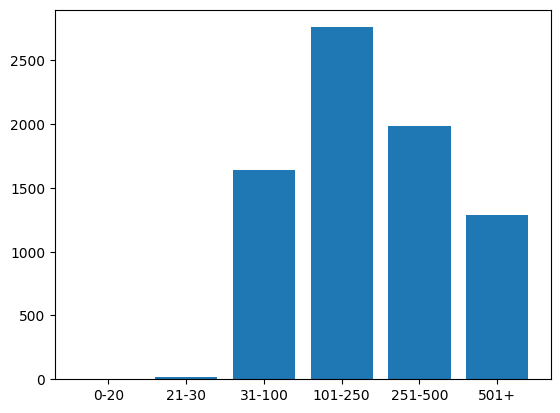

In [20]:
get_histogram(normal_users_num_watched)

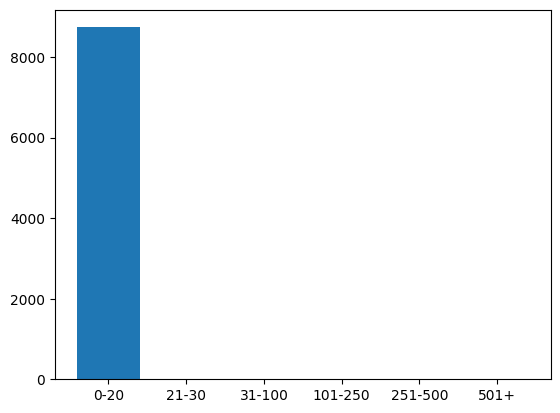

In [21]:
get_histogram(new_users_num_watched)

# Splitting User Ratings into Train and Test Datasets
Split based on the update_at column and save both files as CSVs.

In [22]:
import math
split_ratio = 0.7 # The ratio of anime per user to put in the training set

def train_test_split(ratings_df: pd.DataFrame, split_ratio: float, should_sort = True):
    train_user_ratings = []
    test_user_ratings = []

    for user_id in ratings_df['user_id'].unique():
        # Get the users ratings and sort by the date the rating was last updated
        users_ratings = ratings_df.loc[ratings_df.user_id == user_id]

        if should_sort:
            users_ratings = users_ratings.sort_values(by=['updated_at'])

        if len(users_ratings) < 2:
            print("Error. Not enough ratings to put user in test and train datasets")
        elif len(users_ratings) == 2:
            train_user_ratings.append(users_ratings.loc[users_ratings.index == 0])
            test_user_ratings.append(users_ratings.loc[users_ratings.index == 1])
        else:
            # Determine what index to split the user's ratings by
            split_index = int(math.floor((len(users_ratings)-1) * split_ratio))

            # Append the split datasets
            train_user_ratings.append(users_ratings[:split_index])
            test_user_ratings.append(users_ratings[split_index+1:])

    train_df = pd.concat(train_user_ratings, ignore_index=True)
    test_df = pd.concat(test_user_ratings, ignore_index=True)
    
    # Ensure Columns Have the Same Data Type
    train_df.score.astype('int32')
    test_df.score.astype('int32')
    train_df.user_id.astype('int32')
    test_df.user_id.astype('int32')
    train_df.anime_id.astype('int32')
    test_df.anime_id.astype('int32')
    
    return (train_df, test_df)

(train_df, test_df) = train_test_split(user_ratings_df, split_ratio)
(new_users_train_df, new_users_test_df) = train_test_split(new_users_ratings_df, split_ratio, should_sort=False)

In [23]:
for user_id in new_users_train_df.user_id.unique():
    num_anime_watched = len(new_users_test_df[new_users_test_df.user_id == user_id])
    if num_anime_watched == 0:
        print(user_id, " watched no anime")
        break

In [24]:
train_df.to_csv('data/user_ratings_train.csv')
test_df.to_csv('data/user_ratings_test.csv')
new_users_train_df.to_csv('data/new_user_ratings_train.csv')
new_users_test_df.to_csv('data/new_user_ratings_test.csv')

In [25]:
train_df

,user_id,anime_id,score,status,num_episodes_watched,updated_at
0,0,48561,9,completed,1,2023-01-01 09:37:49+00:00
1,0,20583,9,completed,25,2023-01-01 09:39:58+00:00
2,0,38883,8,completed,13,2023-01-01 09:40:05+00:00
3,0,28891,10,completed,25,2023-01-01 09:40:24+00:00
4,0,32935,9,completed,10,2023-01-01 09:40:42+00:00
...,...,...,...,...,...,...
1919125,9071,4581,4,completed,13,2022-09-27 03:09:40+00:00
1919126,9071,20671,4,completed,1,2022-09-27 03:09:41+00:00
1919127,9071,38787,4,completed,12,2022-09-27 03:09:43+00:00
1919128,9071,2476,4,completed,12,2022-09-27 03:09:44+00:00


In [26]:
test_df

,user_id,anime_id,score,status,num_episodes_watched,updated_at
0,0,32998,9,completed,12,2023-04-15 14:29:11+00:00
1,0,36649,7,completed,24,2023-04-15 14:29:23+00:00
2,0,39533,6,completed,11,2023-04-15 14:30:38+00:00
3,0,31405,6,completed,12,2023-04-15 14:30:59+00:00
4,0,44511,9,completed,12,2023-04-15 14:32:47+00:00
...,...,...,...,...,...,...
827656,9071,227,2,completed,6,2023-07-16 22:56:52+00:00
827657,9071,37171,5,completed,12,2023-09-07 12:21:07+00:00
827658,9071,659,5,completed,1,2023-09-07 12:21:41+00:00
827659,9071,35838,5,completed,12,2023-09-07 12:22:10+00:00


In [27]:
new_users_train_df

,user_id,anime_id,score
0,8,16742,5
1,8,4181,9
2,8,31297,9
3,8,32093,8
4,8,23273,7
...,...,...,...
58939,108932,1186,10
58940,108932,122,2
58941,108932,74,10
58942,108952,23333,10


In [28]:
new_users_test_df

,user_id,anime_id,score
0,8,226,7
1,8,2167,8
2,8,22199,7
3,8,31043,6
4,8,18671,8
...,...,...,...
31604,108932,52,10
31605,108932,99,10
31606,108932,11751,10
31607,108952,25567,9


# Setup the Distance Functions

In [29]:
# Return a distance matrix using cosine distance
def cosine_distance_metric(user_profile, anime_vector_df):
    distance_mat = cosine_distances(np.array([user_profile["weighted_vector_avg"].tolist()]).reshape((1, -1)), anime_vector_df).reshape(-1)
    return distance_mat

# Return a distance matrix using euclidean distance
def euclidean_distance_metric(user_profile, anime_vector_df):
    distance_mat = euclidean_distances(np.array([user_profile["weighted_vector_avg"].tolist()]).reshape((1, -1)), anime_vector_df).reshape(-1)
    return distance_mat

# Return a distance matrix using manhattan distance
def manhattan_distance_metric(user_profile, anime_vector_df):
    distance_mat = manhattan_distances(np.array([user_profile["weighted_vector_avg"].tolist()]).reshape((1, -1)), anime_vector_df).reshape(-1)
    return distance_mat

# Supporting Adding a User's List From MyAnimeList to the User Ratings

In [243]:
from dotenv import load_dotenv
import requests
import time

load_dotenv()

CLIENT_ID = os.getenv('CLIENT_ID') # An ID needed to authenticate requests to the API
print(f'Client ID: {CLIENT_ID}')

MY_ANIME_LIST_API_URL = 'https://api.myanimelist.net/v2' # The URL of the API that will be called upon
API_REQUEST_DELAY = 1 # A delay (in seconds) to prevent over-use of the API

def get_users_list(username: str, new_user_id: int):
    anime_list_request: requests.Response = None
    
    try:
        anime_list_request = requests.get(f'{MY_ANIME_LIST_API_URL}/users/{username}/animelist?fields=list_status&limit=1000', headers={'X-MAL-CLIENT-ID': CLIENT_ID})
        time.sleep(API_REQUEST_DELAY * 2)

        user_anime_list = {"username": username, "anime_list": []}
        anime_list_data = anime_list_request.json().get('data')
        if anime_list_data is not None:
            for node in anime_list_data:
                user_anime_list["anime_list"].append({"anime": node["node"], "list_status": node["list_status"]})

        while anime_list_request.json()['paging'].get('next') is not None:
            time.sleep(API_REQUEST_DELAY * 2)
            
            anime_list_data = anime_list_request.json().get('data')
            if anime_list_data is not None:
                for node in anime_list_data:
                    user_anime_list["anime_list"].append({"anime": node["node"], "list_status": node["list_status"]})
            
            # Get Next 1000 Anime if Available
            if anime_list_request.json()['paging'].get('next') is not None:
                anime_list_request = requests.get(f'{anime_list_request.json()["paging"].get("next")}&fields=list_status', headers={'X-MAL-CLIENT-ID': CLIENT_ID})

        print(f'Found {username}\'s anime list. They watched {len(user_anime_list["anime_list"])} anime...')
        
        user_ratings_dict = {
            "user_id": [],
            "anime_id": [],
            "score": []
        }

        for anime_rating in user_anime_list["anime_list"]:
            if anime_rating["list_status"].get("status") == 'completed' and anime_df.id.isin([anime_rating["anime"]["id"]]).any():
                user_ratings_dict["user_id"].append(new_user_id)
                user_ratings_dict["anime_id"].append(anime_rating["anime"]["id"])
                user_ratings_dict["score"].append(anime_rating["list_status"]["score"])
        
        return pd.DataFrame(data=user_ratings_dict)
    except:
        print(f"Exception occured when trying to perform user anime list request with: {anime_list_request.status_code}")

Client ID: 76344f06bbbdd05c396151b63eee418e


In [227]:
def get_next_user_id(user_ratings_df: pd.DataFrame):
    next_user_id = max(user_ratings_df.user_id.unique()) + 1
    return next_user_id

In [228]:
def add_to_user_ratings(user_list_df: pd.DataFrame, user_ratings_df: pd.DataFrame):
    return pd.concat([user_list_df, user_ratings_df])

# Create the Recommender Systems
This will include a Content-Based Filtering, Collaborative Filtering and Hybrid System.

## Create the Content-Based Filtering Recommender

In [197]:
from sklearn.metrics import mean_squared_error

class CBFRecommender:
    def __init__(self, anime_data: pd.DataFrame, user_ratings_data: pd.DataFrame):
        # Cleanup Anime Data
        self.anime_df = anime_data
        self.anime_df.fillna({"genres": ""}, inplace=True)
        self.anime_df.fillna({"synopsis": ""}, inplace=True)

        self.user_ratings_data = user_ratings_data
        self.users_to_ignore_on_evaluation = []
        self.custom_user_mappings = {} # username: user_id

    # Uses TF-IDF to Vectorize the Anime DataFrame
    def vectorize_anime_data(self, stop_words='english', max_features=50, max_df=0.5, min_df=0.01):
        vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=max_features, max_df=max_df, min_df=min_df)
        anime_features_vector_matrix = vectorizer.fit_transform(self.anime_df['genres'])

        self.anime_vector_df = pd.DataFrame(data=anime_features_vector_matrix.toarray())
        self.anime_vector_df['anime_id'] = self.anime_df['id']
        self.anime_vector_df = self.anime_vector_df.set_index('anime_id')

        return self.anime_vector_df

    # Creates a profile of the specified user
    def create_user_profile(self, user_id: int):
        # Get only this user's ratings
        users_ratings_df = self.user_ratings_data[self.user_ratings_data.user_id == user_id]

        # Prefer to only use anime they rated higher than their avg. rating
        average_rating = np.average(users_ratings_df['score'])
        selected_user_ratings_df = users_ratings_df[users_ratings_df.score >= average_rating]

        # Get the Anime they rated highly
        user_anime_rated_df = self.anime_df[self.anime_df.id.isin(selected_user_ratings_df['anime_id'])]

        # Get the weighted average of the Vector values for the anime they rated
        user_vector_df = self.anime_vector_df.loc[user_anime_rated_df['id']]
        weighted_vector_avg = user_vector_df.mean()

        return {
            "weighted_vector_avg": weighted_vector_avg,
            "vector_df": user_vector_df
        }

    # Get a DataFrame of How Distant Anime Are to the User's Preferences
    def get_user_anime_distance(self, user_id, distance_metric='cosine'):
        # Find user profile in user profiles
        user_profile = self.create_user_profile(user_id)

        # Calculate the distance matrix of the user's weighted vector instance compared to all instances in the anime vector df
        distance_mat = None
        if distance_metric == 'cosine':
            distance_mat = cosine_distance_metric(user_profile, self.anime_vector_df)
        elif distance_metric == 'euclidean':
            distance_mat = euclidean_distance_metric(user_profile, self.anime_vector_df)
        elif distance_metric == 'manhattan':
            distance_mat = manhattan_distance_metric(user_profile, self.anime_vector_df)
        else:
            print(f'Error: The distance metric is invalid. Unable to create distance matric for user with id {user_id}')

        if distance_mat is None:
            print("Error. Couldn't create distance matrix.")
            return None

        # Convert the matrix into a dataframe
        distance_df = pd.DataFrame(data=distance_mat.tolist())
        distance_df = distance_df.rename(columns={0: "distance"})
        distance_df['id'] = self.anime_df['id']

        # Remove all anime that the user has already watched
        distance_df = distance_df.loc[~distance_df.id.isin(user_profile["vector_df"].index)]

        # The closer to 0 the distance is the more similar the anime is to the weighted vector
        distance_df = distance_df.sort_values(by='distance', ascending=True)

        return distance_df

    # Recommend Anime to the User
    def recommend_user(self, user_id, num_recommendations: int, distance_metric='cosine', add_anime_info: bool = True):
        distance_df = self.get_user_anime_distance(user_id, distance_metric=distance_metric)

        # Get the top recommendations and merge the anime data with the dataframe
        top_similar_anime_df = distance_df.iloc[0:num_recommendations]

        if len(top_similar_anime_df) != num_recommendations:
            print(f"Expected {num_recommendations} recommendations, but got {len(top_similar_anime_df)}")

        # Only merge if we want to the anime information too.
        if add_anime_info:
            top_similar_anime_df = top_similar_anime_df.merge(self.anime_df, on='id', how='inner')

        return top_similar_anime_df

    # Adds a new user using a MyAnimeList Username
    def add_new_user_by_mal_username(self, username: str):
        if username in self.custom_user_mappings:
            return self.custom_user_mappings[username]
        
        user_id = get_next_user_id(self.user_ratings_data)
        list_df = get_users_list(username, user_id)

        self.user_ratings_data = pd.concat([self.user_ratings_data, list_df])
        self.users_to_ignore_on_evaluation.append(user_id)
        self.custom_user_mappings[username] = user_id
        
        return user_id
    
    def get_user_anime_scores(self, user_id, distance_metric='cosine'):
        user_scores_df = self.get_user_anime_distance(user_id, distance_metric=distance_metric)
        user_scores_df = user_scores_df.rename(columns={"distance": "score"})
        return user_scores_df

    # Evaluate the effectiveness of this recommender
    def evaluate(self, num_recommendations: int, testing_df: pd.DataFrame, distance_metric='cosine'):
        unique_user_ids = testing_df.user_id.unique()
        
        # Only use users that are in the testing dataframe
        unique_user_ids = testing_df.loc[testing_df.user_id.isin(unique_user_ids)].user_id.unique()
        
        hits = 0
        mean_reciprocal_rank_sum = 0

        # Loop through each user
        for user_id in unique_user_ids:
            if user_id in self.users_to_ignore_on_evaluation:
                continue # Skip this user
            
            # Get that user's recommendations
            user_recommendations = self.recommend_user(user_id, num_recommendations, distance_metric=distance_metric)

            # Get the anime they rated in the testing dataset
            user_testing_anime_df = testing_df.loc[testing_df.user_id == user_id]

            # Get the number of hits for the user in the testing dataset
            user_num_hits = len(user_testing_anime_df.loc[user_testing_anime_df.anime_id.isin(user_recommendations.id)]['anime_id'])
            
            # If There Was a Hit, Add to the Total Hits
            if user_num_hits > 0:
                # Increase the overall number of hits
                hits += 1

                # Determine where in the list the first hit was
                idx = 0
                first_hit_index = 0
                for anime_id in user_recommendations.id:
                    # Is this anime in the user's test ratings?
                    if np.any(user_testing_anime_df.anime_id.values[:] == anime_id):
                        # Set this as the rank and break out of this loop
                        first_hit_index = idx
                        break
                    
                    # Iterate the index
                    idx += 1

                # Calulate the mean reciprocal rank
                mrr = 1 / (first_hit_index + 1)
                mean_reciprocal_rank_sum += mrr
        
        return { "hit_rate": hits / len(unique_user_ids), "mean_reciprocal_rank": mean_reciprocal_rank_sum / len(unique_user_ids)}
    
    # Make recommendations for every user
    def make_recommendations(self, testing_df: pd.DataFrame, num_recommendations=20, distance_metric='cosine'):
        unique_user_ids = self.user_ratings_data['user_id'].unique()
        
        # Only use users that are in the testing dataframe
        unique_user_ids = testing_df.loc[testing_df.user_id.isin(unique_user_ids)].user_id.unique()
        
        recommendations = {}

        for user_id in unique_user_ids:
            # Get this user's recommendations
            actual_anime_vectors = self.anime_vector_df.loc[self.anime_vector_df.index.isin(testing_df.loc[testing_df.user_id == user_id]['anime_id'])]

            if len(actual_anime_vectors) > 0:
                predictions = self.recommend_user(user_id, num_recommendations, distance_metric=distance_metric, add_anime_info = False)
                predicted_anime_vectors = self.anime_vector_df.loc[self.anime_vector_df.index.isin(predictions['id'])]

                # Add them to the dictionary
                recommendations[user_id] = {"actual_anime_vectors": actual_anime_vectors.to_numpy(),
                                            "predictions": predictions,
                                            "prediction_vectors": predicted_anime_vectors.to_numpy()}
            else:
                print("Warning. Not enought anime vectors.")

        return recommendations

## Create the Collaborative Filtering Recommender

In [34]:
import os

from surprise import BaselineOnly, Dataset, Reader, accuracy, SVD, SVDpp, NMF
from surprise.model_selection import GridSearchCV, train_test_split

In [35]:
def convert_user_ratings_to_surprise_dataset(ur_df):  
    surprise_user_ratings_df = ur_df[["user_id", "anime_id", "score"]]
    surprise_user_ratings_df = surprise_user_ratings_df.rename(columns={"user_id": "userID", "anime_id": "itemID", "score": "rating"})
    
    cf_ratings_reader = Reader(rating_scale=(0, 10))
    cf_ratings_data = Dataset.load_from_df(surprise_user_ratings_df, cf_ratings_reader)
    return cf_ratings_data

In [198]:
class CollaborativeFilteringRecommender:
    # The algorithm must be Matrix Factorization algorithm supported by surprise
    def __init__(self, ratings_dataset: pd.DataFrame, mf_algorithm=SVD):
        self.users_to_ignore_on_evaluation = []
        self.custom_user_mappings = {}

        self.ratings_dataset = ratings_dataset
        self.cf_trainset = convert_user_ratings_to_surprise_dataset(ratings_dataset)
        self.cf_trainset = self.cf_trainset.build_full_trainset()
        self.cf_model = mf_algorithm()
        self.mf_algorithm = mf_algorithm
       
        self.cf_model.fit(self.cf_trainset)
    
    def get_user_anime_scores(self, user_id: str):
        user_innerid = self.cf_trainset.to_inner_uid(user_id)
        
        item_ids = list(self.cf_trainset.all_items()).copy()
        all_users_rated_items = self.cf_trainset.ur[user_innerid]

        # Remove anime the user has rated
        for (item_innerid, rating) in all_users_rated_items:
            try:
                item_ids.remove(item_innerid)
            except:
                continue
        
        # Estimate the rating for each item
        item_predictions = []
        for item_innerid in item_ids:
            item_rawid = self.cf_trainset.to_raw_iid(item_innerid)
            prediction = self.cf_model.predict(user_id, item_rawid)
            item_predictions.append(prediction)
    
        user_anime_ids = []
        user_scores = []
        for prediction in item_predictions:
            user_scores.append(prediction.est)
            user_anime_ids.append(int(prediction.iid))
        
        user_scores_dict = {"score": user_scores, "id": user_anime_ids}
        user_scores_df = pd.DataFrame(user_scores_dict)
        
        return user_scores_df
    
    def recommend_user(self, user_innerid, num_recommendations):
        user_recommendations = []
        user_id = self.cf_trainset.to_raw_uid(user_innerid)
        
        item_ids = list(self.cf_trainset.all_items()).copy()
        all_users_rated_items = self.cf_trainset.ur[user_innerid]

        # Remove anime the user has rated
        for (item_innerid, rating) in all_users_rated_items:
            try:
                item_ids.remove(item_innerid)
            except:
                continue
                
        # Estimate the rating for each item
        item_predictions = []
        for item_innerid in item_ids:
            item_rawid = self.cf_trainset.to_raw_iid(item_innerid)
            prediction = self.cf_model.predict(user_id, item_rawid)
            item_predictions.append(prediction)
        
        # Recommend the top N items
        item_predictions.sort(key=lambda x: x.est, reverse=True)
        
        for prediction in item_predictions[:num_recommendations]:
            user_recommendations.append(prediction.iid)
        
        return user_recommendations

    # Adds a new user using a MyAnimeList Username
    def add_new_user_by_mal_username(self, username: str):
        if username in self.custom_user_mappings:
            return self.custom_user_mappings[username]
        
        user_id = get_next_user_id(self.ratings_dataset)
        list_df = get_users_list(username, user_id)
        
        self.users_to_ignore_on_evaluation.append(user_id)
        self.custom_user_mappings[username] = user_id

        self.ratings_dataset = pd.concat([self.ratings_dataset, list_df])
        self.cf_trainset = convert_user_ratings_to_surprise_dataset(self.ratings_dataset)
        self.cf_trainset = self.cf_trainset.build_full_trainset()
        self.cf_model = self.mf_algorithm()
        
        print("Refitting model...")
        self.cf_model.fit(self.cf_trainset)
        print("Finished refitting model...")
              
        return user_id
    
    def evaluate(self, num_recommendations: int, testing_df: pd.DataFrame):
        hits = 0
        mean_reciprocal_rank_sum = 0

        for inner_userid in self.cf_trainset.all_users():
            user_id = self.cf_trainset.to_raw_uid(inner_userid)

            if int(user_id) in self.users_to_ignore_on_evaluation:
                continue # Skip this user
            
            user_recommendations = self.recommend_user(inner_userid, num_recommendations)
            
            user_testing_anime_df = testing_df.loc[testing_df.user_id == user_id]
            user_num_hits = len(user_testing_anime_df.loc[user_testing_anime_df.anime_id.isin(user_recommendations)]['anime_id'])
            
            if user_num_hits > 0:
                # Increase the overall number of hits
                hits += 1
        
                # Determine where in the list the first hit was
                idx = 0
                first_hit_index = 0
                for anime_id in user_recommendations:
                    # Is this anime in the user's test ratings?
                    if np.any(user_testing_anime_df.anime_id.values[:] == anime_id):
                        # Set this as the rank and break out of this loop
                        first_hit_index = idx
                        break
                    
                    # Iterate the index
                    idx += 1

                # Calulate the mean reciprocal rank
                mrr = 1 / (first_hit_index + 1)
                mean_reciprocal_rank_sum += mrr
        
        return {"hit_rate": hits / len(testing_df.user_id.unique()), "mean_reciprocal_rank": mean_reciprocal_rank_sum / len(testing_df.user_id.unique())}
    
    def get_user_recommendations_df(self, user_recommendations: list):
        return anime_df[anime_df.id.isin(user_recommendations)]
    
    def make_recommendations(self, num_recommendations, test_ratings_df, anime_vector_df):
        recommendations = {}
        
        for inner_userid in self.cf_trainset.all_users():
            user_recommendations = self.recommend_user(inner_userid, num_recommendations)
            user_id = self.cf_trainset.to_raw_uid(inner_userid)
            
            actual_anime_vectors = anime_vector_df.loc[anime_vector_df.index.isin(test_ratings_df.loc[test_ratings_df.user_id == user_id]['anime_id'])]
            predicted_anime_vectors = anime_vector_df.loc[anime_vector_df.index.isin(user_recommendations)]
            if len(predicted_anime_vectors) == 0:
                print("No predicted anime vectors were found.")
            
            recommendations[int(user_id)] = {"actual_anime_vectors": actual_anime_vectors.to_numpy(),
                                            "predictions": user_recommendations,
                                            "prediction_vectors": predicted_anime_vectors.to_numpy()}
        
        return recommendations

## Create the Hybrid Recommender

In [185]:
class HybridRecommender:
    def __init__(self, anime_data: pd.DataFrame, user_ratings_data: pd.DataFrame, cbf_distance_metric='cosine'):
        self.cbf_recommender = CBFRecommender(anime_data, user_ratings_data)
        self.cbf_recommender.vectorize_anime_data(stop_words='english', max_features=50, max_df=0.5, min_df=0.01)
        self.cbf_distance_metric = cbf_distance_metric
        self.anime_data = anime_data
        self.user_ratings_data = user_ratings_data
        self.cf_recommender = CollaborativeFilteringRecommender(user_ratings_data)
        self.users_to_ignore_on_evaluation = []
    
    def get_user_combined_scores(self, user_id):
        # Content-Based Filtering
        cbf_scores_df = self.cbf_recommender.get_user_anime_scores(user_id, distance_metric=self.cbf_distance_metric)
        cbf_scores_df = cbf_scores_df.rename(columns={"score": "cbf_score"})
        
        # Collaborative Filtering
        cf_scores_df = self.cf_recommender.get_user_anime_scores(user_id)    
        # Perform Min-Max Normalization
        cf_scores_df["score"] = (cf_scores_df["score"] - cf_scores_df["score"].min()) / (cf_scores_df["score"].max() - cf_scores_df["score"].min())
        cf_scores_df["score"] = (1 - cf_scores_df["score"])
        
        cf_scores_df = cf_scores_df.rename(columns={"score": "cf_score"})
        
        # Combine both into one dataframe
        combined_scores_df = cbf_scores_df.merge(cf_scores_df, on='id', how='inner')
        combined_scores_df['combined_score'] = combined_scores_df['cbf_score'] + combined_scores_df['cf_score']
        combined_scores_df.sort_values(by=['combined_score'], ascending=True, inplace=True)
        
        return combined_scores_df
    
    def recommend_user(self, user_id, num_recommendations):
        user_combined_scores_df = self.get_user_combined_scores(user_id)
        user_top_anime_df = user_combined_scores_df.iloc[:num_recommendations]
        
        return user_top_anime_df

    def add_new_user_by_mal_username(self, username: str):
        cbf_new_user_id = self.cbf_recommender.add_new_user_by_mal_username(username)
        cf_new_user_id = self.cf_recommender.add_new_user_by_mal_username(username)

        if cbf_new_user_id != cf_new_user_id:
            print(f"{cbf_new_user_id} != {cf_new_user_id}")

        self.users_to_ignore_on_evaluation.append(cf_new_user_id)

        return cf_new_user_id
        
    def get_user_anime_recommendations_df(self, user_top_anime_df):
        return anime_df[anime_df.id.isin(user_top_anime_df.id)]
    
    def evaluate(self, num_recommendations: int, testing_df: pd.DataFrame):
        unique_user_ids = testing_df['user_id'].unique()
        
        # Only use users that are in the testing dataframe
        #unique_user_ids = testing_df.loc[testing_df.user_id.isin(unique_user_ids)].user_id.unique()
        
        hits = 0
        mean_reciprocal_rank_sum = 0

        # Loop through each user
        for user_id in unique_user_ids:
            if user_id in self.users_to_ignore_on_evaluation:
                continue # Skip this user
            
            # Get that user's recommendations
            user_recommendations = self.recommend_user(user_id, num_recommendations)

            # Get the anime that user rated from the testing dataset
            user_testing_anime_df = testing_df.loc[testing_df.user_id == user_id]

            # Get the number of the user's hits from the testing dataset
            user_num_hits = len(user_testing_anime_df.loc[user_testing_anime_df.anime_id.isin(user_recommendations.id)]['anime_id'])
           
             # If There Was a Hit, Add to the Total Hits
            if user_num_hits > 0:
                # Increase the overall number of hits
                hits += 1

                # Determine where in the list the first hit was
                idx = 0
                first_hit_index = 0
                for anime_id in user_recommendations.id:
                    # Is this anime in the user's test ratings?
                    if np.any(user_testing_anime_df.anime_id.values[:] == anime_id):
                        # Set this as the rank and break out of this loop
                        first_hit_index = idx
                        break
                    
                    # Iterate the index
                    idx += 1

                # Calculate the mean reciprocal rank
                mrr = 1 / (first_hit_index + 1)
                mean_reciprocal_rank_sum += mrr
        
        return { "hit_rate": hits / len(unique_user_ids), "mean_reciprocal_rank": mean_reciprocal_rank_sum / len(unique_user_ids)}
    
    def make_recommendations(self, num_recommendations, test_ratings_df, anime_vector_df):
        recommendations = {}
        unique_user_ids = self.user_ratings_data['user_id'].unique()
        
        for user_id in unique_user_ids:
            user_recommendations = self.recommend_user(user_id, num_recommendations)
            actual_anime_vectors = anime_vector_df.loc[anime_vector_df.index.isin(test_ratings_df.loc[test_ratings_df.user_id == user_id]['anime_id'])]
            predicted_anime_vectors = anime_vector_df.loc[anime_vector_df.index.isin(user_recommendations['id'])]
            
            recommendations[user_id] = {"actual_anime_vectors": actual_anime_vectors.to_numpy(),
                                            "predictions": user_recommendations,
                                            "prediction_vectors": predicted_anime_vectors.to_numpy()}
        
        return recommendations

# Evaluate the Recommenders

In [148]:
# Pick which distance metric to use for minimum distance evaluation
eval_dist_metric = 'cosine'

## Evaluate the Content-Based Recommender

### Use the Standard Dataset

In [199]:
std_anime_cbf_recommender = CBFRecommender(anime_df, train_df)
std_anime_cbf_recommender.vectorize_anime_data(stop_words='english', max_features=50, max_df=0.5, min_df=0.01)

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
anime_id,,,,,,,,,,,,,,,,,,,,,
5114,0.326361,0.0,0.353823,0.0,0.0,0.000000,0.0,0.000000,0.0,0.392005,...,0.0,0.0,0.442801,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9253,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.427621,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28977,0.297200,0.0,0.000000,0.0,0.0,0.000000,0.0,0.254751,0.0,0.000000,...,0.0,0.0,0.403236,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41467,0.450306,0.0,0.488197,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.610967,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39486,0.279901,0.0,0.000000,0.0,0.0,0.000000,0.0,0.239922,0.0,0.336199,...,0.0,0.0,0.379764,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56512,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56779,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53029,0.000000,0.0,0.000000,0.0,0.0,0.707107,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [143]:
std_cbf_recommender_evaluation = {
    "5": std_anime_cbf_recommender.evaluate(5, test_df),
    "10": std_anime_cbf_recommender.evaluate(10, test_df),
    "20": std_anime_cbf_recommender.evaluate(20, test_df)
}

In [144]:
std_cbf_recommender_evaluation

{'5': {'hit_rate': 0.11737943585077343,
  'mean_reciprocal_rank': 0.05449326227306181},
 '10': {'hit_rate': 0.20447159755621994,
  'mean_reciprocal_rank': 0.06602203817529434},
 '20': {'hit_rate': 0.35330820226179643,
  'mean_reciprocal_rank': 0.07615882980918175}}

### Use the New Users Dataset

In [200]:
new_anime_cbf_recommender = CBFRecommender(anime_df, new_users_train_df)
new_anime_cbf_recommender.vectorize_anime_data(stop_words='english', max_features=50, max_df=0.5, min_df=0.01)

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
anime_id,,,,,,,,,,,,,,,,,,,,,
5114,0.326361,0.0,0.353823,0.0,0.0,0.000000,0.0,0.000000,0.0,0.392005,...,0.0,0.0,0.442801,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9253,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.427621,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28977,0.297200,0.0,0.000000,0.0,0.0,0.000000,0.0,0.254751,0.0,0.000000,...,0.0,0.0,0.403236,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41467,0.450306,0.0,0.488197,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.610967,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39486,0.279901,0.0,0.000000,0.0,0.0,0.000000,0.0,0.239922,0.0,0.336199,...,0.0,0.0,0.379764,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56512,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56779,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53029,0.000000,0.0,0.000000,0.0,0.0,0.707107,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [225]:
new_anime_cbf_recommender.recommend_user(np.random.choice(new_users_train_df.user_id), 5)

,distance,id,title,start_date,end_date,synopsis,score,rank,popularity,num_list_users,...,media_type,status,genres,num_episodes,start_season,broadcast_day,broadcast_time,source,rating,studios
0,0.201240,10360,Kinniku Banzuke: Kongou-kun no Daibouken!,2001-07-30,2001-08-30,A group of school children are invited to comp...,5.04,12422.0,13861,766,...,tv,finished_airing,"Action,Shounen,Sports",3,summer,NaN,NaN,other,pg_13,Pierrot
1,0.214859,51781,Boku no Hero Academia (ONA),2022-06-16,2022-06-16,"Episode 1: HLB\n\nHLB stands for ""Hero League ...",6.82,4906.0,3389,40056,...,ona,finished_airing,"School,Shounen,Sports,Super Power,Team Sports",2,spring,NaN,NaN,manga,pg_13,Bones
2,0.216041,359,I'll/CKBC,2002-12-18,2003-03-26,Pressured by his family's background and expec...,6.19,8282.0,7879,5505,...,ova,finished_airing,"Action,School,Shounen,Sports,Team Sports",2,fall,NaN,NaN,manga,pg_13,M.S.C
3,0.216041,3825,Dokaben,1976-10-06,1979-12-26,"Tarou ""Dokaben"" Yamada, who was a judoist whil...",6.50,6648.0,12301,1217,...,tv,finished_airing,"Action,School,Shounen,Sports,Team Sports",163,fall,wednesday,19:00,NaN,pg_13,Nippon Animation
4,0.216041,8953,Nine,1983-05-04,1983-05-04,"Just before entering Seishuu High School, trac...",6.06,8967.0,13271,906,...,special,finished_airing,"Action,School,Shounen,Sports,Team Sports",1,spring,NaN,NaN,manga,pg_13,Group TAC


In [146]:
new_cbf_recommender_evaluation= {
    "5": new_anime_cbf_recommender.evaluate(5, new_users_test_df),
    "10": new_anime_cbf_recommender.evaluate(10, new_users_test_df),
    "20": new_anime_cbf_recommender.evaluate(20, new_users_test_df)
}

In [147]:
new_cbf_recommender_evaluation

{'5': {'hit_rate': 0.053101396200503546,
  'mean_reciprocal_rank': 0.027140077821011667},
 '10': {'hit_rate': 0.0844586861982147,
  'mean_reciprocal_rank': 0.03132145854450724},
 '20': {'hit_rate': 0.1264591439688716,
  'mean_reciprocal_rank': 0.03417666430778788}}

## Evaluate the Collaborative Recommender

### Use the Standard Dataset

In [201]:
cf_svd_recommender = CollaborativeFilteringRecommender(train_df)

In [109]:
cf_recommender_evaluation = {
    "5": cf_svd_recommender.evaluate(5, test_df),
    "10": cf_svd_recommender.evaluate(10, test_df),
    "20": cf_svd_recommender.evaluate(20, test_df)
}

In [110]:
cf_recommender_evaluation

{'5': {'hit_rate': 0.404653581177694,
  'mean_reciprocal_rank': 0.24526625936998972},
 '10': {'hit_rate': 0.5419212270895619,
  'mean_reciprocal_rank': 0.2638583003720126},
 '20': {'hit_rate': 0.6654101130898219,
  'mean_reciprocal_rank': 0.27256713511800124}}

### Use the New Users Dataset

In [202]:
new_cf_svd_recommender = CollaborativeFilteringRecommender(new_users_train_df)

In [112]:
new_cf_recommender_evaluation = {
    "5": new_cf_svd_recommender.evaluate(5, new_users_test_df),
    "10": new_cf_svd_recommender.evaluate(10, new_users_test_df),
    "20": new_cf_svd_recommender.evaluate(20, new_users_test_df)
}

In [113]:
new_cf_recommender_evaluation

{'5': {'hit_rate': 0.07152666514076447,
  'mean_reciprocal_rank': 0.0398050659952696},
 '10': {'hit_rate': 0.11123826962691691,
  'mean_reciprocal_rank': 0.04507419699397264},
 '20': {'hit_rate': 0.16788738841840237,
  'mean_reciprocal_rank': 0.0489387338292327}}

## Evaluate the Hybrid Recommender

In [203]:
hybrid_recommender = HybridRecommender(anime_df, train_df)

In [137]:
hybrid_recommender_evaluation = {
    "5": hybrid_recommender.evaluate(5, test_df),
    "10": hybrid_recommender.evaluate(10, test_df),
    "20": hybrid_recommender.evaluate(20, test_df)
}

In [138]:
hybrid_recommender_evaluation

{'5': {'hit_rate': 0.486936175744183,
  'mean_reciprocal_rank': 0.30884787035833405},
 '10': {'hit_rate': 0.6200441960223579,
  'mean_reciprocal_rank': 0.3266098432093491},
 '20': {'hit_rate': 0.7283244507994281,
  'mean_reciprocal_rank': 0.3343134218539516}}

In [204]:
new_hybrid_recommender = HybridRecommender(anime_df, new_users_train_df)

In [140]:
new_hybrid_recommender_evaluation = {
    "5": new_hybrid_recommender.evaluate(5, new_users_test_df),
    "10": new_hybrid_recommender.evaluate(10, new_users_test_df),
    "20": new_hybrid_recommender.evaluate(20, new_users_test_df)
}

In [141]:
new_hybrid_recommender_evaluation

{'5': {'hit_rate': 0.11409933623254749,
  'mean_reciprocal_rank': 0.06703860532539853},
 '10': {'hit_rate': 0.15884641794460974,
  'mean_reciprocal_rank': 0.0729685064687353},
 '20': {'hit_rate': 0.21538109407187,
  'mean_reciprocal_rank': 0.07683444954203528}}

## Compare the Recommenders

### Normal Users

#### Hit Rate

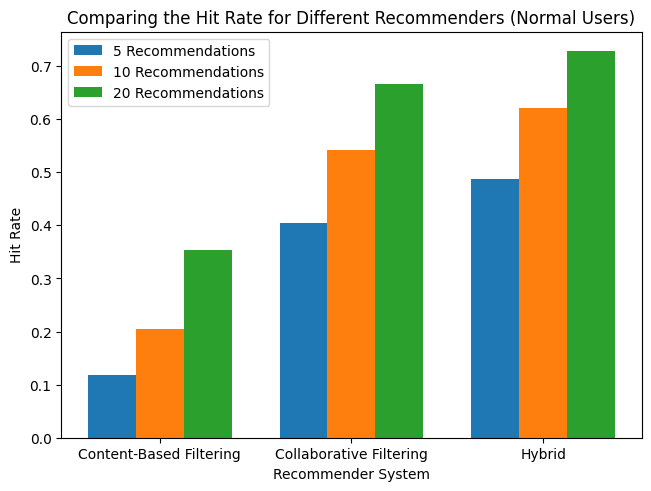

<Figure size 7680x5760 with 0 Axes>

In [149]:
import matplotlib.pyplot as plt

recommender_labels = ['Content-Based Filtering', 'Collaborative Filtering', 'Hybrid']
hit_rates_dict = {
    "5": [std_cbf_recommender_evaluation["5"]["hit_rate"], cf_recommender_evaluation["5"]["hit_rate"], hybrid_recommender_evaluation["5"]["hit_rate"]],
    "10": [std_cbf_recommender_evaluation["10"]["hit_rate"], cf_recommender_evaluation["10"]["hit_rate"], hybrid_recommender_evaluation["10"]["hit_rate"]],
    "20": [std_cbf_recommender_evaluation["20"]["hit_rate"], cf_recommender_evaluation["20"]["hit_rate"], hybrid_recommender_evaluation["20"]["hit_rate"]],
}

x = np.arange(len(recommender_labels)) 
fig, ax = plt.subplots(layout='constrained')
bar_width = 0.25

bar_mult = 0
for num_recommendations, hit_rates in hit_rates_dict.items():
    offset = bar_width * bar_mult
    ax.bar(x + offset, hit_rates, bar_width, label=f"{num_recommendations} Recommendations")
    bar_mult += 1
    
ax.set_ylabel('Hit Rate')
ax.set_xlabel('Recommender System')
ax.set_xticks(x + bar_width, recommender_labels)
ax.set_title('Comparing the Hit Rate for Different Recommenders (Normal Users)')
ax.legend(ncols=1)

plt.savefig('data/hit_rate_normal_users.png', dpi=1200)
plt.figure(dpi=1200)
plt.show()

#### Mean Reciprocal Rank

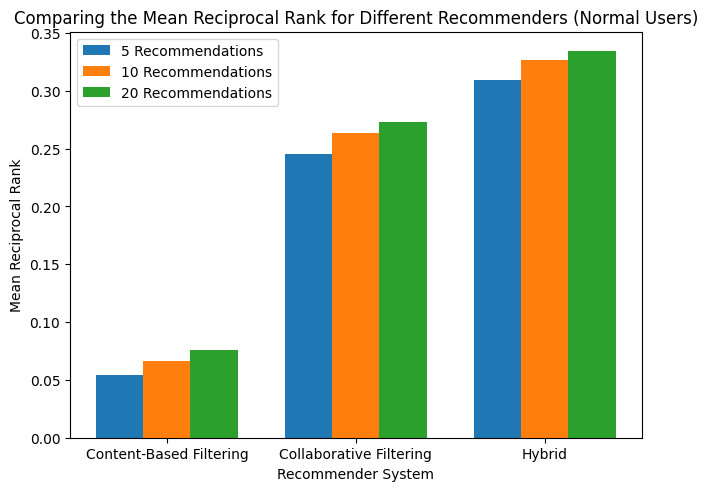

<Figure size 7680x5760 with 0 Axes>

In [150]:
import matplotlib.pyplot as plt

recommender_labels = ['Content-Based Filtering', 'Collaborative Filtering', 'Hybrid']
mean_reciprocal_ranks_dict = {
    "5": [std_cbf_recommender_evaluation["5"]["mean_reciprocal_rank"], cf_recommender_evaluation["5"]["mean_reciprocal_rank"], hybrid_recommender_evaluation["5"]["mean_reciprocal_rank"]],
    "10": [std_cbf_recommender_evaluation["10"]["mean_reciprocal_rank"], cf_recommender_evaluation["10"]["mean_reciprocal_rank"], hybrid_recommender_evaluation["10"]["mean_reciprocal_rank"]],
    "20": [std_cbf_recommender_evaluation["20"]["mean_reciprocal_rank"], cf_recommender_evaluation["20"]["mean_reciprocal_rank"], hybrid_recommender_evaluation["20"]["mean_reciprocal_rank"]],
}

x = np.arange(len(recommender_labels)) 
fig, ax = plt.subplots(layout='constrained')
bar_width = 0.25

bar_mult = 0
for num_recommendations, mean_reciprocal_ranks in mean_reciprocal_ranks_dict.items():
    offset = bar_width * bar_mult
    ax.bar(x + offset, mean_reciprocal_ranks, bar_width, label=f"{num_recommendations} Recommendations")
    bar_mult += 1
    
ax.set_ylabel('Mean Reciprocal Rank')
ax.set_xlabel('Recommender System')
ax.set_xticks(x + bar_width, recommender_labels)
ax.set_title('Comparing the Mean Reciprocal Rank for Different Recommenders (Normal Users)')
ax.legend(ncols=1)

plt.savefig('data/mean_reciprocal_rank_normal_users.png', dpi=1200)
plt.figure(dpi=1200)
plt.show()

### New Users

#### Hit Rate

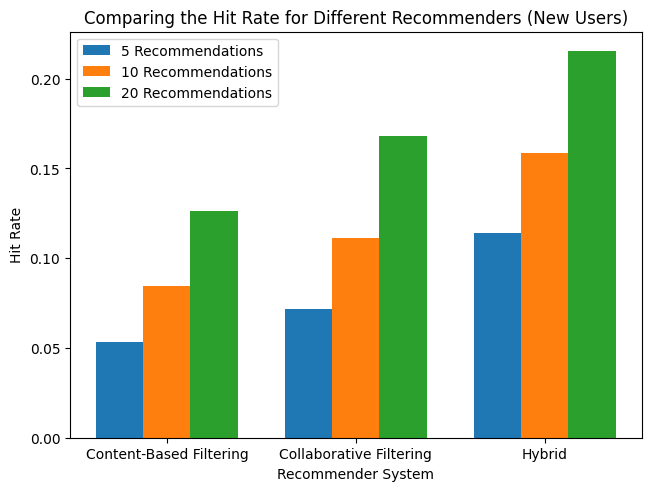

<Figure size 7680x5760 with 0 Axes>

In [151]:
import matplotlib.pyplot as plt

recommender_labels = ['Content-Based Filtering', 'Collaborative Filtering', 'Hybrid']
hit_rates_dict = {
    "5": [new_cbf_recommender_evaluation["5"]["hit_rate"], new_cf_recommender_evaluation["5"]["hit_rate"], new_hybrid_recommender_evaluation["5"]["hit_rate"]],
    "10": [new_cbf_recommender_evaluation["10"]["hit_rate"], new_cf_recommender_evaluation["10"]["hit_rate"], new_hybrid_recommender_evaluation["10"]["hit_rate"]],
    "20": [new_cbf_recommender_evaluation["20"]["hit_rate"], new_cf_recommender_evaluation["20"]["hit_rate"], new_hybrid_recommender_evaluation["20"]["hit_rate"]],
}

x = np.arange(len(recommender_labels)) 
fig, ax = plt.subplots(layout='constrained')
bar_width = 0.25

bar_mult = 0
for num_recommendations, hit_rates in hit_rates_dict.items():
    offset = bar_width * bar_mult
    ax.bar(x + offset, hit_rates, bar_width, label=f"{num_recommendations} Recommendations")
    bar_mult += 1
    
ax.set_ylabel('Hit Rate')
ax.set_xlabel('Recommender System')
ax.set_xticks(x + bar_width, recommender_labels)
ax.set_title('Comparing the Hit Rate for Different Recommenders (New Users)')
ax.legend(ncols=1)

plt.savefig('data/hit_rate_new_users.png', dpi=1200)
plt.figure(dpi=1200)
plt.show()

#### Mean Reciprocal Rank

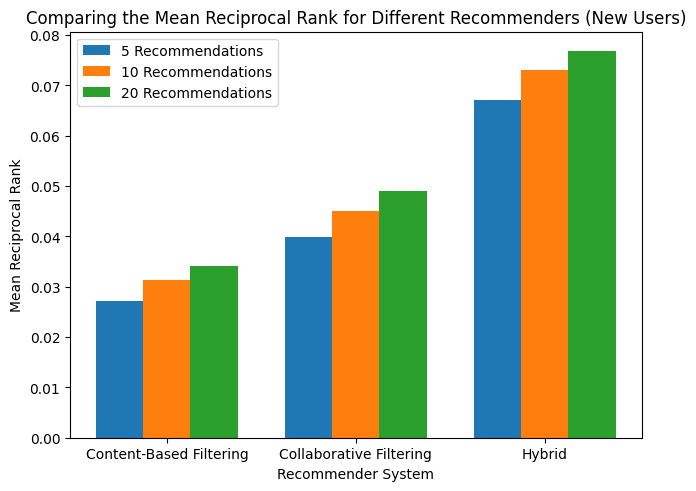

<Figure size 7680x5760 with 0 Axes>

In [152]:
import matplotlib.pyplot as plt

recommender_labels = ['Content-Based Filtering', 'Collaborative Filtering', 'Hybrid']
mean_reciprocal_ranks_dict = {
    "5": [new_cbf_recommender_evaluation["5"]["mean_reciprocal_rank"], new_cf_recommender_evaluation["5"]["mean_reciprocal_rank"], new_hybrid_recommender_evaluation["5"]["mean_reciprocal_rank"]],
    "10": [new_cbf_recommender_evaluation["10"]["mean_reciprocal_rank"], new_cf_recommender_evaluation["10"]["mean_reciprocal_rank"], new_hybrid_recommender_evaluation["10"]["mean_reciprocal_rank"]],
    "20": [new_cbf_recommender_evaluation["20"]["mean_reciprocal_rank"], new_cf_recommender_evaluation["20"]["mean_reciprocal_rank"], new_hybrid_recommender_evaluation["20"]["mean_reciprocal_rank"]],
}

x = np.arange(len(recommender_labels)) 
fig, ax = plt.subplots(layout='constrained')
bar_width = 0.25

bar_mult = 0
for num_recommendations, mean_reciprocal_ranks in mean_reciprocal_ranks_dict.items():
    offset = bar_width * bar_mult
    ax.bar(x + offset, mean_reciprocal_ranks, bar_width, label=f"{num_recommendations} Recommendations")
    bar_mult += 1
    
ax.set_ylabel('Mean Reciprocal Rank')
ax.set_xlabel('Recommender System')
ax.set_xticks(x + bar_width, recommender_labels)
ax.set_title('Comparing the Mean Reciprocal Rank for Different Recommenders (New Users)')
ax.legend(ncols=1)

plt.savefig('data/mean_reciprocal_rank_new_users.png', dpi=1200)
plt.figure(dpi=1200)
plt.show()

# Save the Recommenders
Finally, save the recommenders so they can be used with Streamlit.

In [205]:
import pickle

def write_object(object_inst, file_name):
    with open(file_name, "wb") as fp:
        pickle.dump(object_inst, fp)

In [206]:
# Hybrid
write_object(hybrid_recommender, "data/hybrid_recommender")
write_object(new_hybrid_recommender, "data/new_hybrid_recommender")

# Collaborative
write_object(cf_svd_recommender, "data/collaborative_recommender")
write_object(new_cf_svd_recommender, "data/new_collaborative_recommender")

# Content-Based
write_object(std_anime_cbf_recommender, "data/cbf_recommender")
write_object(new_anime_cbf_recommender, "data/new_cbf_recommender")

## Test Opening One of The Recommender Files

In [207]:
hybrid_recommender_file = open('data/hybrid_recommender', 'rb')
hybrid_recommender = pickle.load(hybrid_recommender_file)

In [208]:
# Test Using My MAL Username
new_user_id = hybrid_recommender.add_new_user_by_mal_username('remlover9000')
hybrid_recommender.recommend_user(new_user_id, 5)

Found remlover9000's anime list. They watched 343 anime...
Found remlover9000's anime list. They watched 343 anime...
Refitting model...
Finished refitting model...


,cbf_score,id,cf_score,combined_score
238,0.427977,4181,0.036156,0.464133
103,0.368075,431,0.125846,0.493922
3,0.254039,2685,0.250746,0.504785
113,0.375297,1033,0.130068,0.505365
0,0.236744,38753,0.271121,0.507864


# Save the Hit Rates

In [209]:
# Hybrid
write_object(hybrid_recommender_evaluation, "data/hybrid_evaluation")
write_object(new_hybrid_recommender_evaluation, "data/new_hybrid_evaluation")
# Collaborative
write_object(cf_recommender_evaluation, "data/cf_evaluation")
write_object(new_cf_recommender_evaluation, "data/new_cf_evaluation")

# Content-Based
write_object(std_cbf_recommender_evaluation, "data/cbf_evaluation")
write_object(new_cbf_recommender_evaluation, "data/new_cbf_evaluation")

## Test Opening One of the Evaluation Files

In [210]:
hybrid_evaluation_file = open('data/hybrid_evaluation', 'rb')
hybrid_evaluation = pickle.load(hybrid_evaluation_file)

In [211]:
hybrid_evaluation

{'5': {'hit_rate': 0.486936175744183,
  'mean_reciprocal_rank': 0.30884787035833405},
 '10': {'hit_rate': 0.6200441960223579,
  'mean_reciprocal_rank': 0.3266098432093491},
 '20': {'hit_rate': 0.7283244507994281,
  'mean_reciprocal_rank': 0.3343134218539516}}